# Draft Quickstart

In this notebook we will familiarize ourselves with weekly player data and design a system to aid in drafting a team for the upcoming season.

The general idea is to train a model that predicts total fantasy points given previous season fantasy data. We can use these predictions to rank players for the upcoming season.

* [Data Prep](#Data-Prep)
* [Modeling](#Modeling)
* [Draft](#Draft)

We need to install a few requirements before getting started.

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn

## Data Prep

The first step is to load the CSV containing our data. We will be using the popular [pandas](https://pandas.pydata.org/docs/getting_started/index.html) package for reading and manipulating data as DataFrames.

In [2]:
import pandas as pd

df = pd.read_csv("../data/draft/player_data.csv")

with pd.option_context("display.max_columns", None):
    display(df)

,player_id,team_id,franchise_id,position_id,name,NFL_draft_year,season,week,vegas_line,beat_line,offensive_snapcount,offensive_snapcount_percentage,defensive_snapcount,defensive_snapcount_percentage,special_team_snapcount,special_team_snapcount_percentage,game_starter,game_location,playoffs,passing_int,passing_rating,passing_yds,passing_two_pt_md,passing_td,passing_att,passing_cmp,receiving_yds,receiving_td,receiving_rec,receiving_tar,rushing_att,rushing_td,rushing_yds,PC01_player_gi,PC02_player_gi,PC03_player_gi,PC04_player_gi,PC05_player_gi,PC06_player_gi,PC07_player_gi,PC08_player_gi,PC09_player_gi,PC10_player_gi,PC11_player_gi,PC12_player_gi,PC13_player_gi,PC14_player_gi,PC15_player_gi,PC16_player_gi,PC17_player_gi,PC18_player_gi,PC19_player_gi,PC20_player_gi,PC21_player_gi,PC22_player_gi,PC23_player_gi,PC24_player_gi,PC25_player_gi,PC26_player_gi,PC27_player_gi,PC28_player_gi,PC29_player_gi,PC30_player_gi,PC31_player_gi,PC32_player_gi,PC33_player_gi,PC34_player_gi,PC35_player_gi,PC36_player_gi,PC37_player_gi,PC38_player_gi,PC39_player_gi,PC40_player_gi,PC41_player_gi,PC42_player_gi,PC43_player_gi,PC44_player_gi,PC45_player_gi,PC46_player_gi,PC47_player_gi,PC48_player_gi,PC49_player_gi,PC50_player_gi,PC51_player_gi,PC52_player_gi,PC53_player_gi,PC54_player_gi,PC55_player_gi,PC56_player_gi,PC57_player_gi,PC58_player_gi,PC59_player_gi,PC60_player_gi,PC61_player_gi,PC62_player_gi,PC63_player_gi,PC64_player_gi,PC65_player_gi,PC66_player_gi,PC67_player_gi,PC1_team_gi,PC2_team_gi,PC3_team_gi,PC1_team_ra,PC2_team_ra,PC3_team_ra
0,3935,8,PHI,OL,Jordan Hicks,2015.0,2018,1,Philadelphia Eagles -1.0,win,0.0,0.0,70.0,100.0,3.0,11.0,1,home,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.535720,10.863385,-7.036347,4.300724,0.689312,-1.798071,-3.086855,-2.179636,-4.609598,-0.693027,-6.717216,0.923689,-1.232957,-3.148344,-2.244902,1.920721,-2.125896,1.738476,4.650081,-0.268336,0.963603,0.552902,-0.261111,-0.443801,0.204616,0.132891,0.219798,0.071654,-0.049206,0.245301,-0.287886,0.030157,0.177201,-0.038076,-1.011855,-0.464725,0.249131,0.451876,-0.163232,0.745244,-1.084854,0.006992,1.813439,-0.282491,-0.274181,-0.463251,-0.458841,-0.118861,-1.370323,3.534788,-0.703772,0.550098,0.554589,-0.788663,1.146566,-0.236809,0.141377,-0.054344,0.201426,-0.534781,-0.040884,0.016196,0.008085,-0.614726,2.898660,-2.111861,3.741353,-1.726173,1.391358,0.066640,-1.726173,1.391358,0.066640
1,1515,8,PHI,DEF,Michael Bennett,NaN,2018,1,Philadelphia Eagles -1.0,win,0.0,0.0,45.0,64.0,3.0,11.0,0,home,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.748709,6.746809,-2.322118,0.476724,-0.462738,1.544923,9.714965,-0.649572,-2.150350,-0.116542,-1.975305,-2.145616,1.494741,0.287055,2.413830,-3.246971,5.788888,6.736237,-5.601859,-0.240620,-3.640138,-2.603294,1.045954,3.401883,-0.135151,0.223147,-1.046409,-0.014465,0.652950,-0.525753,-0.330486,1.093748,3.533005,-0.052667,-1.714427,-0.055342,0.527733,0.406042,0.854149,2.761618,3.363040,0.376782,1.277694,0.478980,-1.416322,-0.733746,-4.036942,0.103636,0.312838,-1.644587,-0.198461,0.048204,-0.007157,0.063867,-0.181326,-0.095199,-0.050519,-0.025132,0.046915,0.370380,0.012867,-0.073527,-0.060662,-0.426245,-1.210598,2.701304,-2.990713,-1.726173,1.391358,0.066640,-1.726173,1.391358,0.066640
2,179,8,PHI,DEF,Haloti Ngata,2006.0,2018,1,Philadelphia Eagles -1.0,win,0.0,0.0,17.0,24.0,3.0,11.0,0,home,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.789653,2.304759,1.215537,-1.297874,-0.423926,0.867490,2.002093,1.781336,2.791333,0.486860,-0.010164,-1.632627,1.138438,0.820813,0.078269,-0.114516,-0.397927,-0.602089,-0.369751,0.176040,0.705845,0.044659,-0.034894,0.329787,0.334217,-0.041404,-1.158495,0.072382,0.691789,-0.263864,1.069238,0.371333,0.911599,0.019992,-0.326847,-0.473590,0.334983,0.500752,-0.224700,0.077506,-1.748041,-0.175123,-0.067239,-0.395301,0.782571,0.171799,-1.539406,-0.081606,-0.728919,1.915300,-0.260874,0.422833,0.241504,-0.151636,0.013344,-0.303983,-0.105880,-0.069470,0.148806,-0.70869

The dataset contains a row for each player for each week they have played.

There are 106 columns, some are informational (names, IDs, etc), some are raw numeric player stats, and the rest are the [principal components](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) of a larger (wider) dataset.

We want to predict total fantasy points for the season, so we will need to create a column that follows our league rules (PPR, pure yardage, etc). 

For the sake of simplicity, let's stick to regular season games and previously earned fantasy points. We will also ignore defensive players, offensive linemen, and kickers.

In [3]:
regular_season_df = df[(df["playoffs"] == 0) & ~df["position_id"].isin({"OL", "DEF", "P", "K"})].reset_index(drop=True)

In [4]:
# how many fantasy points is 1 of each worth
fantasy_weights = {
    "passing_int": -2,
    "passing_yds": 0.04,
    "passing_two_pt_md": 2,
    "passing_td": 4,
    "receiving_yds": 0.1,
    "receiving_td": 6,
    "receiving_rec": 1, # set to 0 for non-PPR
    "rushing_td": 6,
    "rushing_yds": 0.1,
}

def get_fantasy_points(game):
    return sum(game[column] * weight for column, weight in fantasy_weights.items() 
               if not pd.isna(game[column]))

# apply with axis="columns" will apply our fantasy points calculation to each row in the DataFrame
regular_season_df["fantasy_points"] = regular_season_df.apply(get_fantasy_points, axis="columns")

In [5]:
regular_season_df = regular_season_df[["player_id", "name", "position_id", "season", "fantasy_points"]]

We now have the rows and columns we care about, but on a weekly basis. To make season level predictions, we will need to aggregate our features by season. Let's compute the seasonal average and total for the fantasy_points column.

In [6]:
seasonal_df = regular_season_df.groupby(["player_id", "name", "position_id", "season"]).sum()
seasonal_df = seasonal_df.reset_index()
seasonal_df

,player_id,name,position_id,season,fantasy_points
0,2,Justin Gage,WR,2003,62.8
1,2,Justin Gage,WR,2004,27.6
2,2,Justin Gage,WR,2005,77.6
3,2,Justin Gage,WR,2006,10.8
4,2,Justin Gage,WR,2007,142.0
...,...,...,...,...,...
11719,27397,Jeff Smith,WR,2019,2.2
11720,27400,Ishmael Hyman,WR,2019,5.4
11721,27404,Wes Hills,RB,2019,16.2
11722,27410,Spencer Schnell,WR,2019,0.0


We can explore the target distribution by position.

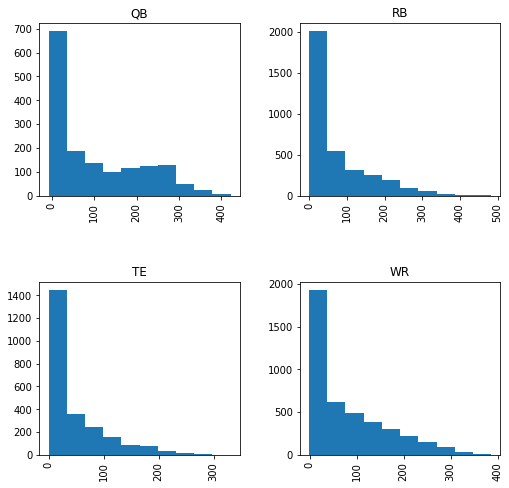

In [7]:
import matplotlib.pyplot as plt

seasonal_df.hist("fantasy_points", by="position_id", figsize=(8, 8))
plt.show()

## Modeling

The model we are building is called an autoregressive model. It predicts future values based on past values. In our case, that means predicting next year's total fantasy points with one or more past season totals.

We will add several past season averages and totals (or "lags") to each row.

In [8]:
lag_features = ["fantasy_points"]
for lag in range(1, 6):
    shifted = seasonal_df.groupby("player_id").shift(lag)
    seasonal_df = seasonal_df.assign(**{f"lag_{column}_{lag}": shifted[column] 
                          for column in lag_features})
seasonal_df = seasonal_df.fillna(-1)
seasonal_df

,player_id,name,position_id,season,fantasy_points,lag_fantasy_points_1,lag_fantasy_points_2,lag_fantasy_points_3,lag_fantasy_points_4,lag_fantasy_points_5
0,2,Justin Gage,WR,2003,62.8,-1.0,-1.0,-1.0,-1.0,-1.0
1,2,Justin Gage,WR,2004,27.6,62.8,-1.0,-1.0,-1.0,-1.0
2,2,Justin Gage,WR,2005,77.6,27.6,62.8,-1.0,-1.0,-1.0
3,2,Justin Gage,WR,2006,10.8,77.6,27.6,62.8,-1.0,-1.0
4,2,Justin Gage,WR,2007,142.0,10.8,77.6,27.6,62.8,-1.0
...,...,...,...,...,...,...,...,...,...,...
11719,27397,Jeff Smith,WR,2019,2.2,-1.0,-1.0,-1.0,-1.0,-1.0
11720,27400,Ishmael Hyman,WR,2019,5.4,-1.0,-1.0,-1.0,-1.0,-1.0
11721,27404,Wes Hills,RB,2019,16.2,-1.0,-1.0,-1.0,-1.0,-1.0
11722,27410,Spencer Schnell,WR,2019,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


We now have all the data we need for modeling. In order to fairly evaluate our future model, we must split the data into train and test sets. 

We will use the 2018 and 2019 seasons for testing.

In [9]:
train_df = seasonal_df[seasonal_df["season"] < 2018].reset_index(drop=True)
test_df = seasonal_df[seasonal_df["season"] >= 2018].reset_index(drop=True)

We can look at the correlation plot to determine how many lags should be included in the model.

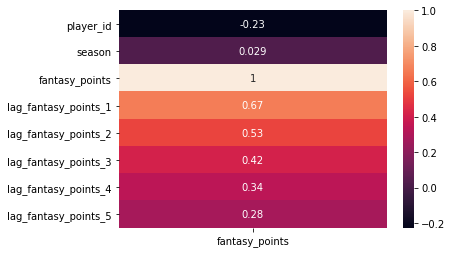

In [10]:
import seaborn as sns

sns.heatmap(train_df.corr()[["fantasy_points"]], annot=True)
plt.show()

As expected, the correlation decays as we look back at past seasons dropping below significance (~0.5) after ~2 seasons.

Let's define a simple modeling pipeline.

First we need to import modules from scikit-learn (sklearn). sklearn includes a wealth of out-of-the-box machine learning algorithms with consistent interfaces for training and prediction.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

We will use 2 previous seasons' fantasy points as features to our model. This is based on the correlation computed from before.

In [12]:
features = [
    "lag_fantasy_points_1", 
    "lag_fantasy_points_2", 
]

The `Pipeline` class is an abstraction that allows us to compose preprocessing and predictive algorithms to ensure consistent handling of train and test data.

Our pipeline will [center and scale](https://stats.stackexchange.com/a/29783) our inputs and feed them into a [regularized Linear Regression](https://medium.com/@zxr.nju/the-classical-linear-regression-model-is-good-why-do-we-need-regularization-c89dba10c8eb).

In [13]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", ElasticNet())
])

The next step defines a [grid search](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e) over a couple of regularization parameters controlling the strength of regularization as well as the [type of regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).

The grid search will ensure we find the best model to fit our data.

In [14]:
param_grid = {
    "lr__alpha": [0.001, 0.01, 0.1, 1, 10], # regularization strength
    "lr__l1_ratio": [0.1, 0.2, 0.5, 0.8, 0.9, 1.0] # type of regulariztion
}
grid = GridSearchCV(pipeline, n_jobs=-1, param_grid=param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_df[features], train_df["fantasy_points"])

print(f"Found best parameters: {grid.best_params_}")

Found best parameters: {'lr__alpha': 0.001, 'lr__l1_ratio': 1.0}


Finally, we can evaluate the trained model. We compare the train and test metrics to ensure we have not [overfit](https://towardsdatascience.com/what-are-overfitting-and-underfitting-in-machine-learning-a96b30864690) to our training data.

In [15]:
train_mae = mean_absolute_error(train_df["fantasy_points"], grid.predict(train_df[features]))

test_df["predicted_fantasy_points"] = grid.predict(test_df[features])
test_mae = mean_absolute_error(test_df["fantasy_points"], test_df["predicted_fantasy_points"])

print(f"train mae: {train_mae}, test mae: {test_mae}")

train mae: 45.242530437086366, test mae: 45.825492952668036


The value of 45.8 indicates that on average, we are ~46 points off (+-) the true value.

## Draft

All that's left to do is sort our test DataFrame by our predicted fantasy points and group by position.

Here we can see the top 10 projected players by position for the 2019 season.

In [16]:
draft_df = test_df[test_df["season"] == 2019].sort_values("predicted_fantasy_points", ascending=False)
positions, position_dfs = zip(*draft_df.groupby("position_id"))

rows = [{} for _ in range(10)]
for position, position_df in draft_df.groupby("position_id"):
    for i, (_, player) in enumerate(position_df.head(10).iterrows()):
        rows[i][position] = player["name"]
        rows[i][f"{position}_predicted"] = player["predicted_fantasy_points"]
        rows[i][f"{position}_points"] = player["fantasy_points"]
    
pd.DataFrame(rows)

,QB,QB_predicted,QB_points,RB,RB_predicted,RB_points,TE,TE_predicted,TE_points,WR,WR_predicted,WR_points
0,Patrick Mahomes,278.927273,289.04,Todd Gurley,288.704311,223.40,Travis Kelce,227.638434,256.3,DeAndre Hopkins,259.580144,268.54
1,Matt Ryan,265.698497,275.34,Christian McCaffrey,281.020278,471.20,Zach Ertz,215.118126,217.6,Antonio Brown,251.282861,16.10
2,Ben Roethlisberger,254.511807,12.74,Alvin Kamara,269.898219,250.52,George Kittle,192.621071,222.5,Julio Jones,249.131187,274.10
3,Deshaun Watson,245.471868,324.98,Le'Veon Bell,265.119065,217.00,Eric Ebron,175.027888,86.5,Tyreek Hill,246.745372,188.30
4,Russell Wilson,242.071239,330.60,Saquon Barkley,256.966129,244.10,Jared Cook,157.000411,167.5,Davante Adams,246.027969,214.70
5,Jared Goff,240.863793,257.52,Ezekiel Elliott,245.191806,315.70,Austin Hooper,137.420316,191.7,Michael Thomas,243.647548,374.60
6,Drew Brees,235.478522,224.76,Melvin Gordon,220.614436,186.80,Kyle Rudolph,134.413014,113.7,Adam Thielen,236.152122,114.40
7,Dak Prescott,230.525439,339.78,James White,205.926831,202.20,Jason Witten,132.607818,141.9,JuJu Smith-Schuster,224.836212,115.20
8,Kirk Cousins,229.789246,248.42,James Conner,198.392637,147.50,Trey Burton,125.252113,22.4,Mike Evans,218.590390,232.70
9,Aaron Rodgers,228.112659,282.38,Kareem Hunt,194.773459,101.40,David Njoku,123.664805,15.1,Keenan Allen,211.717302,261.50


We obviously haven't accounted for injury (Ben Roethlisberger) or controversy (Antonio Brown) in this model. This shows that the real world is full of variables outside of our control and model results should be considered informed guesses and not always taken at face value. 

Other Gridironers have experimented with more complex models capable of quantifying uncertainty in predictions which can hopefully allow us to begin accounting for the randomness inherent in these kinds of problems.

## Next Steps

This is an extremely simple model meant to get you up and running on your own. Other things that may be useful include
* Use raw features instead of (or in addition to) the simple autoregressive model may allow the model to exploit more granular patterns.
* Different features may be more useful in predicting performance for certain positions -- it may be worth experimenting with position-specific models.
* Linear regression and its variants are extremely simple models, try other algorithms ([random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), [gradient boosted trees](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor), [neural networks](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)) to get a better sense of latent signal in the data. 
* Players can have a meaningful effects on each other's fantasy performance, consider adding things like QB stats to receiver predictions.
* Rookies are left out of this ranking since they have no previous seasons in the NFL. What kind of dataset could we use to build a rookie model?
* We don't actually care about the raw number of points scored, but rather the ranking. [There are models optimized for this specific use case.](https://medium.com/@tacucumides/learning-to-rank-with-lightgbm-code-example-in-python-843bd7b44574)